# Аналитика интернет-магазина

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 100
import warnings
warnings.filterwarnings('ignore')

## Приоритизация гипотез

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')

Получили список гипотез с параметрами

In [3]:
hypothesis.columns=['hypothesis','reach','impact','confidence','efforts']

In [4]:
print(hypothesis)

                                                                                            hypothesis  \
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                     Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   
5             Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...   
7     Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
8                                             

Применим фреймворк ICE для приоритизации гипотез

In [5]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

print(hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).round(2))

                                                                                            hypothesis  \
8                                              Запустить акцию, дающую скидку на товар в день рождения   
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7     Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
5             Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                     Изменить цвет фона главн

Применим фреймворк RICE для приоритизации гипотез

In [6]:
hypothesis['RICE']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
print(hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False))

                                                                                            hypothesis  \
7     Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...   
8                                              Запустить акцию, дающую скидку на товар в день рождения   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
5             Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
4                     Изменить цвет фона главн

Формулы расчета отличаются коеффициентом reach. У 7 и 2 гипотез они 10 и 8 соответственно, больше, чем все остальные. Поэтому эти гипотезы переместились на верхние строчки.

## Анализ A/B-теста

### Обзор файлов

Имеем 2 файла с результатами A/B-теста

In [7]:
orders=pd.read_csv('orders.csv')
visitors=pd.read_csv('visitors.csv')

In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Чуть-чуть преобразуем файлы

In [10]:
orders.columns=['transactionid','visitorid','date','revenue','group']

In [11]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим на дубли в группах

In [13]:
ordersA=orders[orders['group']=='A']
groupA=ordersA[['visitorid','group']]
ordersB=orders[orders['group']=='B']
groupB=ordersB[['visitorid','group']]
groupAB=groupA.merge(groupB,on='visitorid',how='inner')
groupAB

,visitorid,group_x,group_y
0,4069496402,A,B
1,199603092,A,B
2,199603092,A,B
3,199603092,A,B
4,199603092,A,B
...,...,...,...
178,4186807279,A,B
179,4186807279,A,B
180,2712142231,A,B
181,2949041841,A,B


In [14]:
groupAB_counts=groupAB['visitorid'].value_counts()
groupAB_counts

2458001652    30
4256040402    28
2378935119    20
2038680547    15
1230306981     6
237748145      4
3717692402     4
199603092      4
3803269165     4
3062433592     4
457167155      3
1614305549     3
2587333274     3
1738359350     2
393266494      2
2044997962     2
1404934699     2
3984495233     2
1294878855     2
3891541246     2
1668030113     2
2780786433     2
4186807279     2
477780734      1
1602967004     1
1801183820     1
3766097110     1
2686716486     1
1333886533     1
351125977      1
3656415546     1
3951559397     1
3234906277     1
3963646447     1
1959144690     1
2654030115     1
4266935830     1
2949041841     1
2954449915     1
3941795274     1
4069496402     1
8300375        1
232979603      1
2927087541     1
818047933      1
2716752286     1
963407295      1
2712142231     1
471551937      1
4120364173     1
276558944      1
1648269707     1
2579882178     1
3202540741     1
3957174400     1
1316129916     1
2600415354     1
3972127743     1
Name: visitori

In [15]:
groupAB_counts.count()

58

In [16]:
orders['visitorid'].nunique()

1031

 58 : 1031 = 5.6% уникальных пользователей попали в обе группы, на которых приходится 181 :1197 = 15% всех покупок

In [17]:
groupAB_counts=groupAB_counts.reset_index()
list_errors1 = groupAB_counts[groupAB_counts['visitorid']==1]['index']
list_errors1

23     477780734
24    1602967004
25    1801183820
26    3766097110
27    2686716486
28    1333886533
29     351125977
30    3656415546
31    3951559397
32    3234906277
33    3963646447
34    1959144690
35    2654030115
36    4266935830
37    2949041841
38    2954449915
39    3941795274
40    4069496402
41       8300375
42     232979603
43    2927087541
44     818047933
45    2716752286
46     963407295
47    2712142231
48     471551937
49    4120364173
50     276558944
51    1648269707
52    2579882178
53    3202540741
54    3957174400
55    1316129916
56    2600415354
57    3972127743
Name: index, dtype: int64

In [18]:
orders[orders['visitorid'].isin(list_errors1)].sort_values(by='visitorid')

,transactionid,visitorid,date,revenue,group
703,4293855558,8300375,2019-08-07,1790,A
71,3679129301,8300375,2019-08-01,10510,B
1009,2670069237,232979603,2019-08-31,2640,B
1013,83566152,232979603,2019-08-31,60,A
85,1701653566,276558944,2019-08-22,12350,B
...,...,...,...,...,...
1070,1473132782,4069496402,2019-08-12,640,B
1021,969750843,4120364173,2019-08-31,15500,B
627,4212256267,4120364173,2019-08-29,39800,A
682,1216533772,4266935830,2019-08-29,78990,B


Как выяснилось даже записи с единичным пересечением это не дубли,а разные покупки, попавшие в разные группы.

По идее такие данные вообще нельзя принимать к рассмотрению. Но хотя бы из файла покупок уберем двойные visitorId и соответствено уберем количество из файла visitors (не может быть покупки без визита). При всем при этом еще неизвестно сколько визитеров без покупок попали в обе группы.

In [19]:
list_errors = groupAB['visitorid'].unique()
orders_d= orders[orders['visitorid'].isin(list_errors)]
orders_d.sort_values(by='visitorid')

,transactionid,visitorid,date,revenue,group
703,4293855558,8300375,2019-08-07,1790,A
71,3679129301,8300375,2019-08-01,10510,B
823,2971973105,199603092,2019-08-27,2790,A
246,437656952,199603092,2019-08-02,3488,B
26,2223239646,199603092,2019-08-15,3488,A
...,...,...,...,...,...
187,2048878902,4256040402,2019-08-17,1550,A
114,1120327437,4256040402,2019-08-01,5800,A
60,1421016313,4256040402,2019-08-16,56650,B
662,1811671147,4266935830,2019-08-29,78990,A


In [20]:
dоubles=orders_d.groupby(['date','group']).count()['visitorid'].reset_index()
dоubles

,date,group,visitorid
0,2019-08-01,A,1
1,2019-08-01,B,4
2,2019-08-02,A,1
3,2019-08-02,B,1
4,2019-08-03,B,2
5,2019-08-04,A,5
6,2019-08-04,B,3
7,2019-08-05,A,3
8,2019-08-05,B,2
9,2019-08-06,A,3


In [21]:
visitors=visitors.merge(dоubles,on=['date','group'],how='outer').fillna(0)
visitors['visitors_new']=visitors['visitors']-visitors['visitorid']
visitors

,date,group,visitors,visitorid,visitors_new
0,2019-08-01,A,719,1.0,718.0
1,2019-08-02,A,619,1.0,618.0
2,2019-08-03,A,507,0.0,507.0
3,2019-08-04,A,717,5.0,712.0
4,2019-08-05,A,756,3.0,753.0
...,...,...,...,...,...
57,2019-08-27,B,720,5.0,715.0
58,2019-08-28,B,654,6.0,648.0
59,2019-08-29,B,531,5.0,526.0
60,2019-08-30,B,490,3.0,487.0


In [22]:
visitors=visitors[['date','group','visitors_new']]
visitors.columns=['date','group','visitors']
visitors['visitors']=visitors['visitors'].astype(int)
visitors

,date,group,visitors
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-03,A,507
3,2019-08-04,A,712
4,2019-08-05,A,753
...,...,...,...
57,2019-08-27,B,715
58,2019-08-28,B,648
59,2019-08-29,B,526
60,2019-08-30,B,487


In [23]:
orders = orders[~orders['visitorid'].isin(list_errors)]
orders

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


### Выручка по группам

посмотрим кумулятивную выручку по группам

In [24]:
datesGroups = orders[['date','group']].drop_duplicates()

In [25]:
ordersAggregated =datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionid' : pd.Series.nunique,
'visitorid' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [26]:
ordersAggregated.head()

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [27]:
visitorsAggregated  = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),axis=1,).sort_values(by=['date', 'group'])

In [28]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,718
66,2019-08-01,B,709
175,2019-08-02,A,1336
173,2019-08-02,B,1289
291,2019-08-03,A,1843


In [29]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']) 
cumulativeData.columns =[ 
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors']
print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       718
1 2019-08-01     B      17      17    59758       709
2 2019-08-02     A      42      36   234381      1336
3 2019-08-02     B      40      39   221801      1289
4 2019-08-03     A      66      60   346854      1843


Построим графики

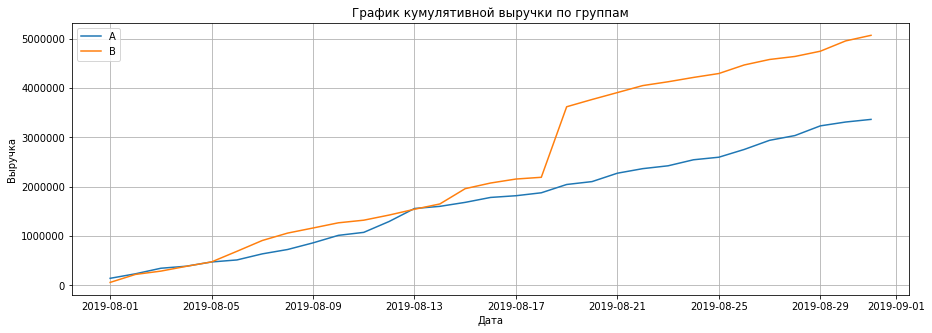

In [30]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize = (15,5))
plt.grid(True)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('График кумулятивной выручки по группам')
plt.show()

Выручка растет, но для группы B наблюдается резкий скачок

### Средний чек

Посмотрим уровень среднего чека по группам на графике

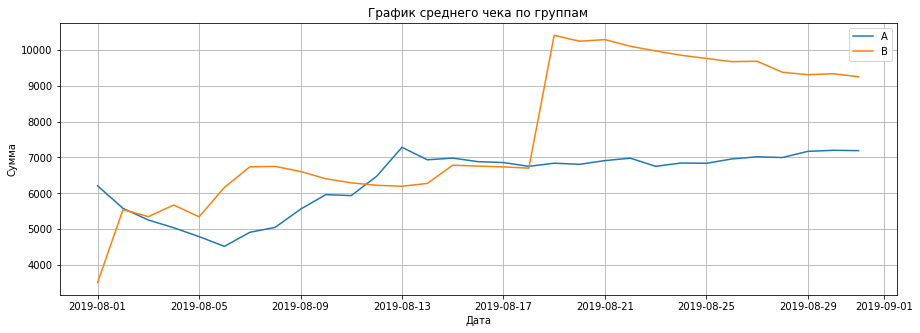

In [31]:
plt.figure(figsize = (15,5))
plt.grid(True)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.title('График среднего чека по группам')
plt.show()

Стоимость среднего чека группы A, можно сказать, равномерна, а в группе B был резкий всплеск и постепенный возврат к обычному уровню. 

### График относительного изменения кумулятивного среднего чека группы B к группе A

Объединим группы

In [32]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Построим график отношений чеков

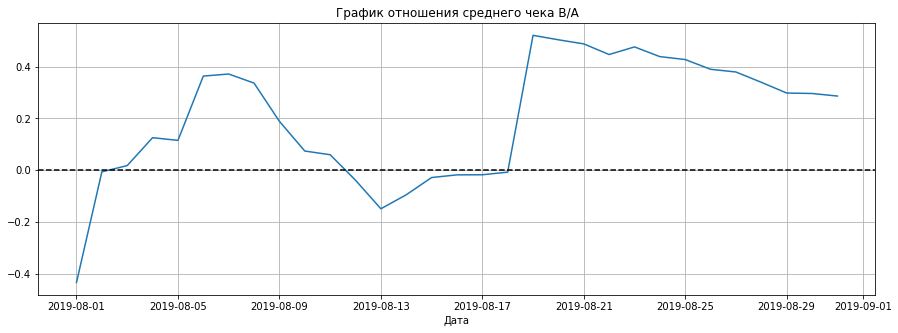

In [33]:
plt.figure(figsize = (15,5))
plt.grid(True)
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.title('График отношения среднего чека B/A')
plt.show()

По графику видно, что имеются крупные покупки и выбросы, график среднего чека далек от стабилизации.  

### График кумулятивной конверсии по группам

посчитаем кумулятивную конверсию по группам

In [34]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

 построим графики

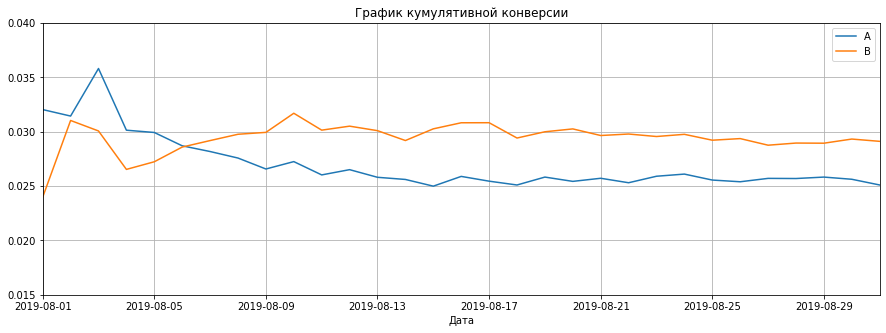

In [35]:
plt.figure(figsize = (15,5))
plt.grid(True)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0.015, 0.04])
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии')
plt.show()

К концу рассматриваемого периода графики выровнялись и зафиксировались

###  График относительного изменения кумулятивной конверсии

Построим график относительного различия кумулятивных конверсий

['2019-08-01', '2019-08-31', -0.3, 0.3]

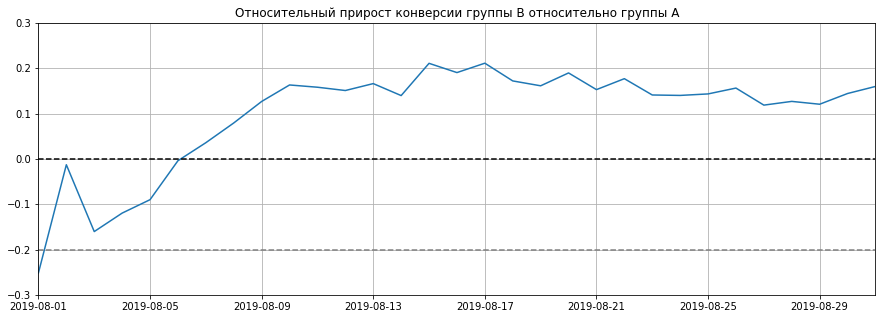

In [36]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize = (15,5))
plt.grid(True)
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.3, 0.3]) 

В середине периода прирост конверсии был самый высокий, видимо связано с большими покупками.

### График количества заказов по пользователям

In [37]:
ordersByUsers = orders[['transactionid','visitorid']].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique,})
ordersByUsers.columns=['userId','orders']
ordersByUsers.sort_values(by='orders',ascending=False)

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


Посмотрим на графике

Text(0.5, 1.0, 'Количество покупок на 1 пользователя')

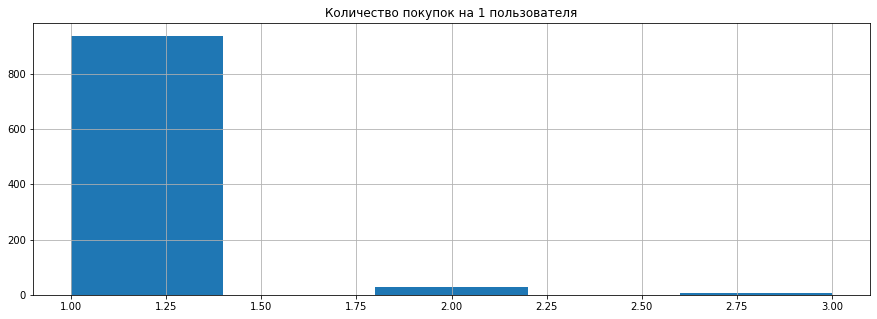

In [38]:
plt.figure(figsize = (15,5))
plt.grid(True)
plt.hist(ordersByUsers['orders'],bins=5)
plt.title('Количество покупок на 1 пользователя');

Свыше 800 пользователей сделали  по 1 покупке

Посмотрим  на диаграмме распределения

Text(0.5, 1.0, 'Количество покупок на 1 пользователя')

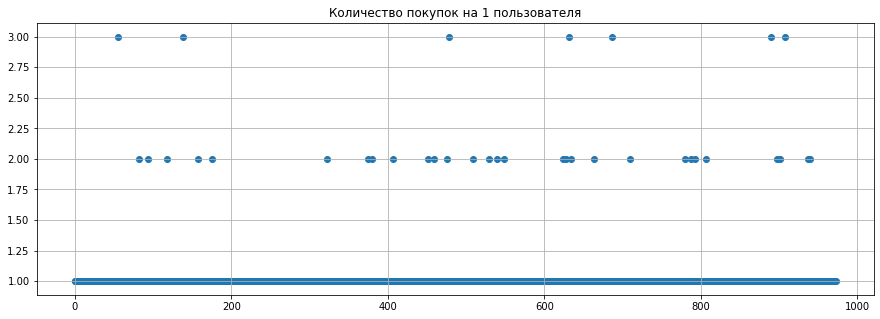

In [39]:
plt.figure(figsize = (15,5))
plt.grid(True)
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество покупок на 1 пользователя')

Единичные случаи, когда покупок больше одной

###   Определение границы аномальных пользователей

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [40]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

Получается, что уже 2 заказа можно считать выбросами

### График стоимости заказов и определение границы заказов с аномальной стоимостью

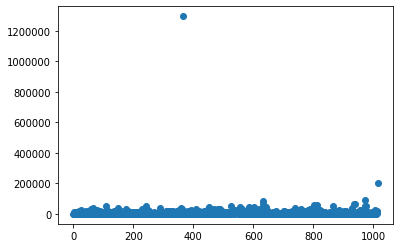

In [41]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

In [42]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

У 5% заказов стоимость больше 26785

### Статистическая значимость различий в конверсии между группами по «сырым» данным

#### Подготовка даных

Подготовим данные для расчета статистической значимости различий

In [43]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

Кумулятивные

In [44]:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]



Все объединим

In [45]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


In [46]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

#### Расчет

Проверим критерием Манна-Уитни. Нулевая гипотеза:статистически значимых различий в конверсии между группами нет.Альтернативная гипотеза: Конверсии групп не равны.

In [47]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [48]:
print('p-value =',"{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

p-value = 0.00548


In [49]:
print('Относительный прирост конверсии группы B =',"{0:.1%}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1)) 

Относительный прирост конверсии группы B = 16.0%


p-value = 0.00548 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный прирост конверсии группы B к А - 16%.
По «сырым» данным различия в конверсии групп A и B есть.

### Cтатистическая значимость различий в среднем чеке между группами по «сырым» данным

Нулевая гипотеза:статистически значимых различий в среднем чеке между группами нет.Альтернативная гипотеза: средние чеки групп не равны.

In [50]:
print('p-value =','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительные различия в среднем чеке =','{0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.415
Относительные различия в среднем чеке = 28.7%


По "сырым" данным P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но относительное различие - 28.7%

### Cтатистическую значимость различий в конверсии между группами по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 26 785 рублей

Посмотрим, сколько всего аномальных пользователей 

In [51]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64

In [52]:
abnormalUsers.shape

(58,)

Удалим аномальных пользователей

In [53]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам. Нулевая гипотеза:статистически значимых различий в конверсии между группами нет. Альтернативная гипотеза: конверсии групп не равны. 

In [54]:
print('p-value =','{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост конверсии группы B =','{0:.1%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.00614
Относительный прирост конверсии группы B = 18.2%


Цифры практически не изменились.
p-value = 0.00614 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный прирост конверсии группы B к А - 18.2%. По «очищенным» данным различия в конверсии групп A и B есть.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза:статистически значимых различий в среднем чеке между группами нет. Альтернативная гипотеза:средние чеки групп не равны.

In [55]:
print('p-value =',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительный различия в среднем чеке =',
    "{0:.1%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.323
Относительный различия в среднем чеке = -4.8%


По "очищенным " данным P-value 0.323 значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. А относительное различие - -4.8%, группа В даже ушла в минус.

Результаты не изменились, но значительно уменьшились различия.

## Выводы

Получили результаты:

1.По «сырым» данным различия в конверсии групп A и B есть.p-value = 0.00548.Относительный прирост конверсии группы B = 16.0%
И по «очищенным» данным различия в конверсии групп A и B есть.
p-value = 0.00614
Относительный прирост конверсии группы B = 18.2%.

2.По "сырым" данным P-value 0.415 значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но относительное различие - 28.7%

По "очищенным " данным P-value 0.323 значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. А относительное различие - -4.8%: уменьшилось, даже изменился знак.

Результаты не изменились, но значительно уменьшились различия в средних чеках


3.График различия конверсии между группами сообщает, что результаты застабилизировались

['2019-08-01', '2019-08-31', -0.3, 0.3]

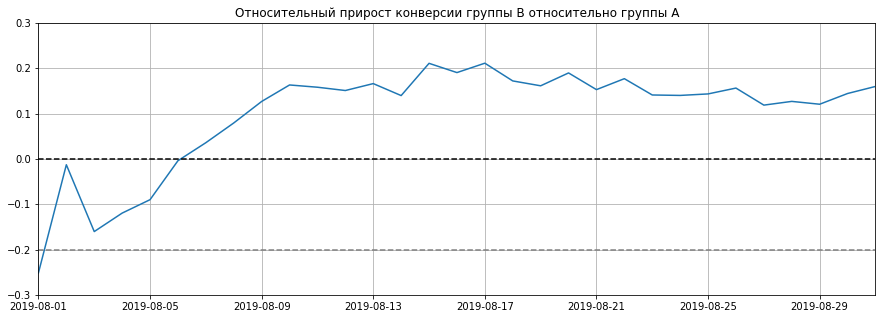

In [56]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize = (15,5))
plt.grid(True)
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.3, 0.3]) 

4.График различия среднего чека говорит о том, что чеки в группе B выше, но после удаления выбросов разница уменьшилась.Статистически значимых отличий не выявлено.

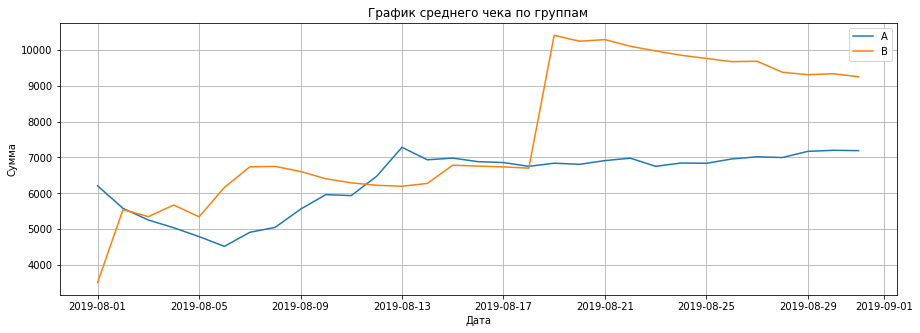

In [57]:
plt.figure(figsize = (15,5))
plt.grid(True)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.title('График среднего чека по группам')
plt.show()

По этим результатам можно сделать вывод, что в данном варианте нет смысла продолжать тестирование, хотя у группы B есть относительный прирост конверсии, отличный от A. Возможно дело в том, что из-за неправильно собранных данных на начальном этапе пришлось удалить 15% записей с покупками,т.к. там была перепутаница с группами. Если возможно, надо привести исходные файлы в порядок, четко разделив пользователей по группам и повторить расчет. 

**Итог:** Мы обнаружили, что график конверсии стабилизировался, статистически значимые различия в конверсии есть, группа В лучше группы А по конверсии. График среднего чека еще не стабилизировался, статистически значимых различий в среднем чеке нет, все отличия мы могли получить и случайно. Тогда ждать стабилизации среднего чека не нужно: группа В лучше группы А по конверсии при равном среднем чеке. Можно зафиксировать победу группы В.